In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
data = pd.read_csv("uio_clean.csv")


In [3]:
data.columns
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,dist_meters,wait_sec
0,1,Quito,2016-09-17 09:32:06,2016-09-17 10:05:51,-78.503922,-0.232824,-78.549447,-0.361363,N,2025,24228,346
1,2,Quito,2016-09-18 04:03:20,2016-09-18 04:26:30,-78.440306,0.006789,-78.490786,-0.104836,N,1390,16680,456
2,3,Quito,2016-09-16 06:29:36,2016-09-18 06:41:33,-78.469551,-0.143636,-78.470277,-0.131083,N,130317,1987,290
3,4,Quito,2016-09-18 05:57:47,2016-09-18 06:30:00,-78.558076,-0.278241,-78.430220,-0.201934,N,1933,25146,302
4,5,Quito,2016-09-18 07:58:42,2016-09-18 08:14:29,-78.521818,-0.208480,-78.504558,-0.222462,N,948,4625,314


In [4]:
data['pickup_datetime'] = pd.to_datetime(data.pickup_datetime)
data['dropoff_datetime'] = pd.to_datetime(data.dropoff_datetime)

data['Day'] = data['pickup_datetime'].dt.weekday_name
data['Year'] = data['pickup_datetime'].dt.year
data['Month'] = data['pickup_datetime'].dt.month
data["date"] = data['pickup_datetime'].dt.date
data["hour"] = data['pickup_datetime'].dt.hour


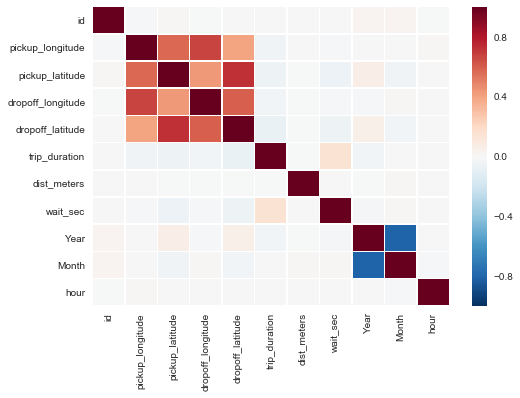

In [5]:
sns.heatmap(data.corr(), linewidths = 0.5)
plt.show()

## Waiting time stats

In [6]:
data["wait_sec"].values.mean(), data["wait_sec"].values.std()

(22040582.569208428, 731162292.75848973)

In [7]:
data.wait_sec.min(), data.wait_sec.max()

(0, 95163057054)

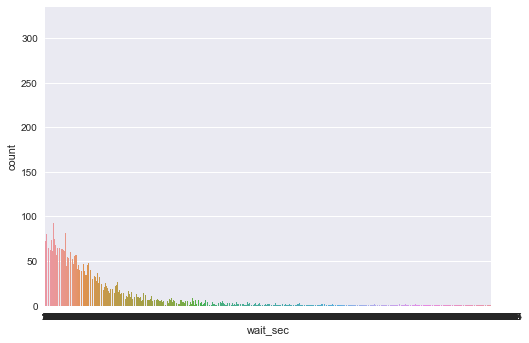

In [8]:
sns.countplot(data['wait_sec'],label="Count")
plt.show()

In [9]:
# Remove outliers
data = data[data.wait_sec < 10000] # limit max wait time to 3 hrs 

data.wait_sec.mean(), data.wait_sec.std(), data.wait_sec.median()

(466.81944575508794, 856.4328012103185, 238.0)

## Waiting time as a function of pickup_datetime

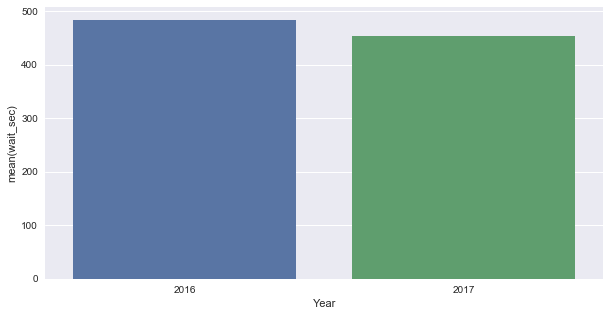

In [10]:
fig, ax = plt.subplots(figsize = (10, 5))
ax = sns.barplot(x = 'Year', y = 'wait_sec', data = data, ci = False)
plt.show()

In [11]:
index = data[data["Year"] == 2014].index.tolist()
data = data.drop(index)

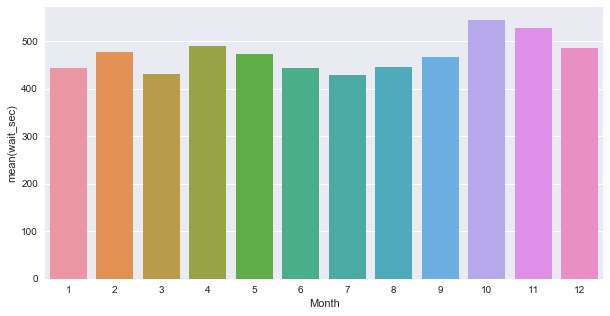

In [12]:
fig, ax = plt.subplots(figsize = (10, 5))
ax = sns.barplot(x = 'Month', y = 'wait_sec', data = data, ci = False)
plt.show()

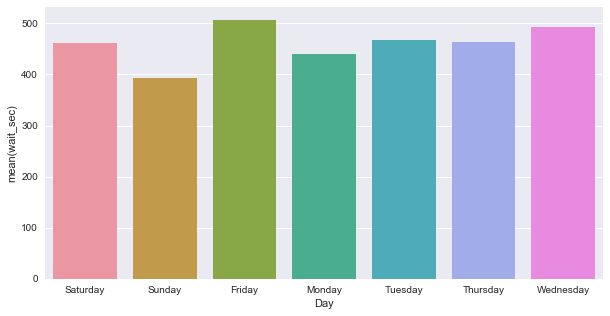

In [13]:
fig, ax = plt.subplots(figsize = (10, 5))
ax = sns.barplot(x = 'Day', y = 'wait_sec', data = data, ci = False)
plt.show()

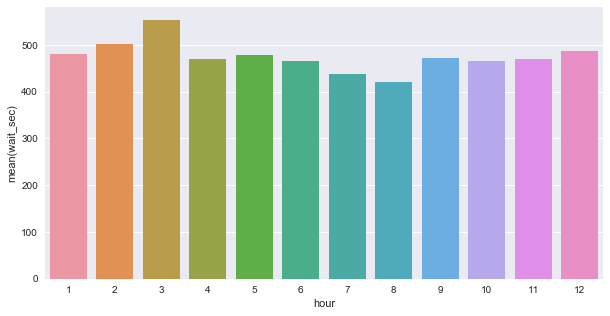

In [14]:
fig, ax = plt.subplots(figsize = (10, 5))
ax = sns.barplot(x = 'hour', y = 'wait_sec', data = data, ci = False)
plt.show()

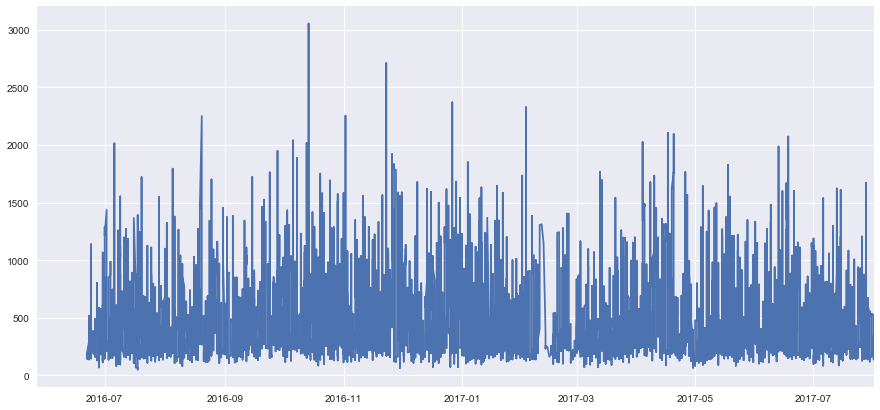

In [15]:
data_time = data[["date", "wait_sec"]]
data_time = data_time.sort_values(by = ["date"])

wait_sec_time_series = pd.Series(data_time["wait_sec"].values, 
                                 index = data_time["date"].values)


X = pd.Series.rolling(wait_sec_time_series,window = 10).mean()
X.plot(figsize = (15,7))
plt.show()

## Waiting time as a function of trip location

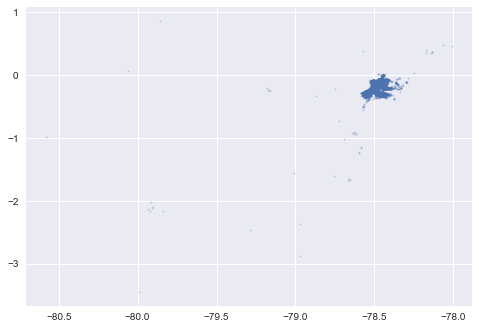

In [16]:
Y = data.pickup_latitude.values.tolist()
X = data.pickup_longitude.values.tolist()

fig = plt.figure()
plt.scatter(X,Y, alpha = 0.3, s = 2)
plt.show()

### Waiting time as a function of pickup location

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


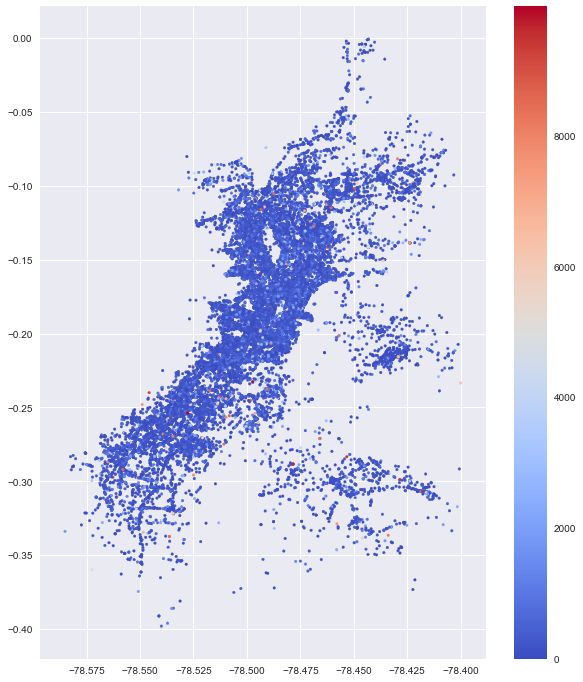

In [17]:
data_closer = data[data.pickup_longitude > -78.6][data.pickup_longitude < -78.4][data.pickup_latitude > -0.4][data.pickup_latitude < 0]
X_closer = data_closer['pickup_longitude']
Y_closer = data_closer['pickup_latitude']

wait_sec = data_closer["wait_sec"].values

from matplotlib import cm
fig = plt.figure(figsize = (10,12))

plt.scatter(X_closer,Y_closer, s = 7, c= wait_sec, cmap=cm.coolwarm)
plt.colorbar()
plt.show()

### Waiting time as a function of dropoff location

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


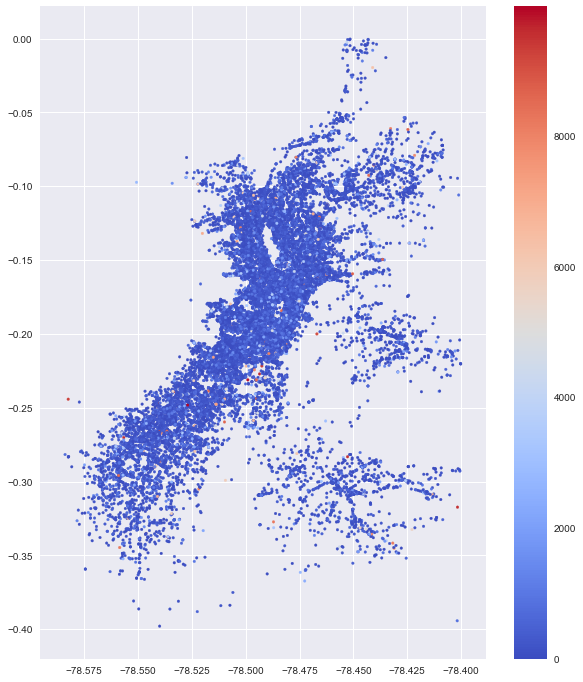

In [18]:
data_closer = data[data.dropoff_longitude > -78.6][data.dropoff_longitude < -78.4][data.dropoff_latitude > -0.4][data.dropoff_latitude < 0]


X_closer = data_closer['dropoff_longitude']
Y_closer = data_closer['dropoff_latitude']
wait_sec = data_closer["wait_sec"].values

from matplotlib import cm
fig = plt.figure(figsize = (10,12))

plt.scatter(X_closer,Y_closer, s = 7, c= wait_sec, cmap=cm.coolwarm)
plt.colorbar()
plt.show()

# Waiting time prediction model

The waiting time is treated as a function of the following features

* Pickup location 
* Dropoff location 
* Pickup datetime

The Pickup datetime is further broken down into the categorical features Year, month, day of week, hour of day. 

We use a **random forest regressor** model for prediction waiting time. 

In [19]:
from sklearn.preprocessing import LabelEncoder 
le = LabelEncoder()
le.fit(data.Day.values.tolist())
data["Day_encoded"] = le.transform(data.Day.values)



In [20]:
model_features = ["pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude", "Year", "Month","Day_encoded", "hour", "wait_sec"]

data_model = data[model_features]
# Train-test split
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(data_model, test_size = 0.3, random_state = 42)

train_set_X = train_set[model_features[:-1]].values
train_set_Y = train_set[model_features[-1]].values
test_set_X = test_set[model_features[:-1]].values
test_set_Y = test_set[model_features[-1]].values

print(np.shape(train_set), np.shape(test_set))

(22253, 9) (9538, 9)


In [21]:
from sklearn.ensemble import RandomForestRegressor as RFR
model = RFR(n_estimators = 500, max_leaf_nodes = 128)
model.fit(train_set_X, train_set_Y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=128,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [22]:
model_pred_Y = model.predict(test_set_X)


In [23]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(model_pred_Y, test_set_Y)
rmse = np.sqrt(mse)
print(rmse)

850.944895758
